<a href="https://colab.research.google.com/github/Dani-Halegua/Projet_ECG/blob/main/Projet_ECG_Partie2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Machine Learning / Image
# Dani Halegua, Luca Champesting et Idyano Leroy

## 2e partie 

Le but est de cette 2e partie est d'utiliser le DNN pré-entraîné de "Ribeiro et al." et de le réutiliser sur de nouvelles données ECG.

Pour ce faire, nous utiliserons dans un premier temps le transfert learning, c'est à dire qu'on va geler les couches du DNN, en modifiant la dernière couche de sorte à ce qu'elle colle à la structure de nos nouvelles données (on doit prédire 4 anomalies au lieu de 6).

Dans un deuxième temps, afin d'améliorer notre modèle, nous ferons du fine tuning, c'est à dire que nous allons dé-geler les couches du DNN pour que le modèle puisse améliorer son apprentissage sur nos nouvelles données.



In [ ]:
pip install wfdb

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

from keras.models import load_model
from tensorflow.keras.optimizers import Adam 
import seaborn as sns


from tqdm import tqdm
import wfdb
import ast
from google.colab import drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##  Récupération des données pour la phase d'entraînement

In [5]:
path_data='/content/gdrive/MyDrive/PROJET_ML/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip'

In [7]:

!unzip '/content/gdrive/MyDrive/PROJET_ML/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip' 


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/07000/07817_lr.dat  
  inflating: __MACOSX/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/07000/._07817_lr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/07000/07359_lr.hea  
  inflating: __MACOSX/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/07000/._07359_lr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/07000/07408_lr.hea  
  inflating: __MACOSX/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/07000/._07408_lr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/07000/07259_lr.hea  
  inflating: __MACOSX/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records1

Les données saturent la RAM, pour pallier à ce problème, on a décidé d'utiliser seulement les 5000 premières données.

In [6]:
def load_raw_data(df, sampling_rate, path):
    data = []
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        i=0
        for f in tqdm(df.filename_hr):
            data.append(wfdb.rdsamp(path+f))
            i+=1

    data = np.array([signal for signal, meta in data])
    return data

path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


# Load raw signal data
Y=Y[0:5000]
X = load_raw_data(Y, sampling_rate, path)   #on charge qu'une partie des données pour pas que la RAM explose

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

FileNotFoundError: ignored

In [10]:
print("Taille de Y",Y.shape)
print("Taille de X_train",X_train.shape)
print("Taille de X_test",X_test.shape)
print("Taille de y_train",y_train.shape)
print("Taille de y_test",y_test.shape)


Taille de Y (5000, 28)
Taille de X_train (4376, 5000, 12)
Taille de X_test (624, 5000, 12)
Taille de y_train (4376,)
Taille de y_test (624,)


In [11]:
def delete_unk_ecg(x,y):
    y = list(y)
    x_processed,y_processed = [],[]
    for index,dis in enumerate(y):
        if dis != []:
            x_processed.append(x[index])
            y_processed.append(y[index])
    return x_processed,y_processed


X_train,y_train = delete_unk_ecg(X_train,y_train)
X_test,y_test = delete_unk_ecg(X_test,y_test)
            
y_train = np.array(y_train,dtype=object)
y_test = np.array(y_test,dtype=object)
X_train = np.array(X_train)
X_test = np.array(X_test)


In [12]:
print(y_train.shape)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(4327,)
(4327, 5000, 12)
(615, 5000, 12)
(615,)


## Transformer le y_train dans un format utilisable
    

In [13]:
#Define the diseases
diseases = ["NORM","MI","HYP","CD","STTC"]

#Create a RIBEIRO format training data
def Ribeiro_convert(y_train):
    
    y_train = list(y_train)

    y_train_ = [[0,0,0,0] for i in list(y_train)]
    for index, info in enumerate(y_train):

        for disease in info:

            if disease != 'NORM':
                y_train_[index][diseases.index(disease)-1] = 1

    y_train_ = np.array(y_train_)
    return y_train_

y_train = Ribeiro_convert(y_train)
y_test = Ribeiro_convert(y_test)

print(y_train.shape)
print(y_test.shape)


##Reformat the ECG aquisition, 4048 samples needed.

(4327, 4)
(615, 4)


## Rescale les données
    Ribeiro is adaptated to 400Hz/10sec : 4096 samples, on this dataset the ECG are converted into 5000 samples array, we have to interpolate and convert array with shape (5000,) into (4096,)
    

In [14]:
import cv2 # opencv

def convert_X(X,scale):
    X_conv = np.empty((X.shape[0], 4096, 12))
    for index,array in enumerate(X):
        array = cv2.resize(array,(12,scale))
        X_conv[index,:,:]=array
    return X_conv
    
X_train_=convert_X(X_train,4096)    
X_test_=convert_X(X_test,4096)    

print(X_train.shape)
print(X_train_.shape)
print(X_test.shape)
print(X_test_.shape)

(4327, 5000, 12)
(4327, 4096, 12)
(615, 5000, 12)
(615, 4096, 12)


In [ ]:
pip install matplotlib==3.1.3 

y= [1 0 0 0]
Disease = MI


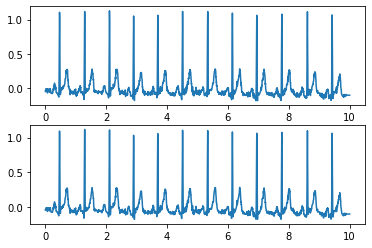

In [17]:


y = np.linspace(0,10,5000)
y_ =np.linspace(0,10,4096)


ObsID=7     #you can change the obsevations here
ChannelID=0 #you can change the channel here

plt.subplot(2, 1, 1)
plt.plot(y,X_train[ObsID,:,ChannelID])
plt.subplot(2, 1, 2)
plt.plot(y_,X_train_[ObsID,:,ChannelID])

print('y=',y_train[ObsID])

if (y_train[ObsID][0]==1):
    print("Disease = MI")
elif (y_train[ObsID][1]==1):
    print("Disease = HYP")
elif (y_train[ObsID][2]==1):
    print("Disease = CD")
elif (y_train[ObsID][3]==1):
    print("Disease = STTC")


In [18]:
X_train_.shape

(4327, 4096, 12)

#Transfert learning
Le but du transfert learning est de ré-utiliser un modèle performant déjà entrainé pour une tâche similaire (ici la classification d'images) dans le but d'améliorer notre propre modèle.

Plus précisément, les 4 étapes du transfert learning sont les suivantes :

 - Charger un modèle déjà entrainé avec les poids qu'il a appris
 - Freeze toutes ses couches en fixant ``trainable = False`` (pour éviter  de détruire les informations obtenues par le modèle de base)
 - Rajouter un petit modèle de classification en sortie du modèle de base pour prédire à l'aide des anciennes features
 - Entrainer notre nouveau modèle sur notre dataset.


In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from keras import Model

In [47]:
base_model = load_model(f"/content/gdrive/MyDrive/PROJET_ML/model/model.hdf5", compile=False)




In [48]:
base_model.trainable = False

last_output = base_model.layers[:-1][-1].output #on récupère l'avant dernière sortie

conv_top = Dense(4096,activation='relu', trainable=True)(last_output)   #On rajoute une couche de classification
conv_top = Dense(4,activation='sigmoid', trainable=True)(conv_top)   

model1 = Model(inputs=base_model.input, outputs=conv_top)


In [44]:
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 signal (InputLayer)            [(None, 4096, 12)]   0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4096, 64)     12288       ['signal[0][0]']                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 4096, 64)    256         ['conv1d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 4096, 64)     0           ['batch_normalization_1[0][

In [49]:
import matplotlib.pyplot as plt 

def plot_learning_curves(history):                         #petit programme pour afficher l'évolution de la loss lors de l'entrainement
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

Epoch 1/20
28/28 [==============================] - 6s 115ms/step - loss: 0.4095 - val_loss: 0.4447
Epoch 2/20
28/28 [==============================] - 3s 101ms/step - loss: 0.4060 - val_loss: 0.4421
Epoch 3/20
28/28 [==============================] - 3s 100ms/step - loss: 0.4008 - val_loss: 0.4466
Epoch 4/20
28/28 [==============================] - 3s 100ms/step - loss: 0.3975 - val_loss: 0.4409
Epoch 5/20
28/28 [==============================] - 3s 100ms/step - loss: 0.3954 - val_loss: 0.4384
Epoch 6/20
28/28 [==============================] - 3s 100ms/step - loss: 0.3916 - val_loss: 0.4349
Epoch 7/20
28/28 [==============================] - 3s 101ms/step - loss: 0.3905 - val_loss: 0.4268
Epoch 8/20
28/28 [==============================] - 3s 100ms/step - loss: 0.3924 - val_loss: 0.4222
Epoch 9/20
28/28 [==============================] - 3s 101ms/step - loss: 0.3908 - val_loss: 0.4328
Epoch 10/20
28/28 [==============================] - 3s 100ms/step - loss: 0.3863 - val_loss: 0.4263

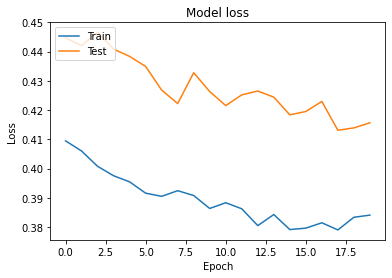

In [51]:
model1.compile(loss = 'binary_crossentropy', optimizer = Adam()
              )

epochs = 20
batch_size = 128
history = model1.fit(X_train_, y_train, batch_size = batch_size , epochs = epochs, validation_split=0.2)
plot_learning_curves(history)

## Evaluation du modèle 
Comme pour la 1ère partie du projet nous évaluerons notre modèle avec l'accuracy, le F1-score et la matrice de confusion. On évalue notre modèle pour les 4 anomalies que nous cherchons à détecter. 

Premièrement, on doit transformer les probabilités calculées par notre DNN en prédictions 0 ou 1, on utilisera le seuil de 0.5 (si la probabilité qu'un patient possède une anomalie est supérieure à 50%, alors on prédira que le patient est atteint de cette anomalie).

In [54]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [1]:
sum(y_test[:,0])

NameError: ignored

In [55]:
model1_pred = model1.predict(X_test_)

In [56]:
model1_pred

array([[0.05616953, 0.04622551, 0.03067736, 0.15969916],
       [0.05625955, 0.04069826, 0.07703725, 0.10723074],
       [0.23924497, 0.19708422, 0.3008057 , 0.24409407],
       ...,
       [0.40022588, 0.22915116, 0.49655914, 0.3637629 ],
       [0.29156333, 0.21973811, 0.76276064, 0.28983483],
       [0.04876403, 0.03572192, 0.02961349, 0.15709482]], dtype=float32)

In [65]:
pred1 = np.zeros((model1_pred.shape[0],4))
for i in range(model1_pred.shape[0]):
  for j in range (4):
    pred1[i,j]=np.round(model1_pred[i,j])   #seuil 0.5


pred1=pd.DataFrame(pred1, columns =["MI","HYP","CD","STTC"])

In [66]:
pred1

,MI,HYP,CD,STTC
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
610,0.0,0.0,0.0,0.0
611,0.0,0.0,0.0,0.0
612,0.0,0.0,0.0,0.0
613,0.0,0.0,1.0,0.0


### MI : Myocardial Infarction

In [80]:
c1 = confusion_matrix(pred1.iloc[:,0],y_test[:,0])
print(c1)
f1 = f1_score(pred1.iloc[:,0],y_test[:,0])
print("Pourcentage d'erreur du dnn pour MI", (1-accuracy_score(pred1.iloc[:,0],y_test[:,0]))*100, " % ")
print("f1-score du dnn pour MI :",f1)


[[479 116]
 [  8  12]]
Pourcentage d'erreur du dnn pour MI 20.16260162601626  % 
f1-score du dnn pour MI : 0.16216216216216214


### HYP : hypertrophy

In [82]:
c2 = confusion_matrix(pred1.iloc[:,1],y_test[:,1])
print(c2)
f2 = f1_score(pred1.iloc[:,1],y_test[:,1])
print("Pourcentage d'erreur du dnn pour HYP", (1-accuracy_score(pred1.iloc[:,1],y_test[:,1]))*100, " % ")
print("f1-score du dnn pour HYP :",f2)

[[544  71]
 [  0   0]]
Pourcentage d'erreur du dnn pour HYP 11.544715447154474  % 
f1-score du dnn pour HYP : 0.0


### CD : Conduction Disturbance

In [83]:
c3 = confusion_matrix(pred1.iloc[:,2],y_test[:,2])
print(c3)
f3 = f1_score(pred1.iloc[:,2],y_test[:,2])
print("Pourcentage d'erreur du dnn pour CD", (1-accuracy_score(pred1.iloc[:,2],y_test[:,2]))*100, " % ")
print("f1-score du dnn pour CD :",f3)

[[491  73]
 [  8  43]]
Pourcentage d'erreur du dnn pour CD 13.170731707317074  % 
f1-score du dnn pour CD : 0.5149700598802395


### STTC : ST/T Change

In [84]:
c4 = confusion_matrix(pred1.iloc[:,3],y_test[:,3])
print(c4)
f4 = f1_score(pred1.iloc[:,3],y_test[:,3])
print("Pourcentage d'erreur du dnn pour STTC", (1-accuracy_score(pred1.iloc[:,3],y_test[:,3]))*100, " % ")
print("f1-score du dnn pour STTC :",f4)

[[462 124]
 [ 13  16]]
Pourcentage d'erreur du dnn pour STTC 22.276422764227643  % 
f1-score du dnn pour STTC : 0.18934911242603547


# Fine tunning

In [86]:
base_model.trainable = True
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 signal (InputLayer)            [(None, 4096, 12)]   0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4096, 64)     12288       ['signal[0][0]']                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 4096, 64)    256         ['conv1d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 4096, 64)     0           ['batch_normalization_1[0][

Epoch 1/20
55/55 [==============================] - 15s 187ms/step - loss: 0.3773 - val_loss: 0.4192
Epoch 2/20
55/55 [==============================] - 10s 173ms/step - loss: 0.3797 - val_loss: 0.4216
Epoch 3/20
55/55 [==============================] - 10s 173ms/step - loss: 0.3746 - val_loss: 0.4205
Epoch 4/20
55/55 [==============================] - 10s 173ms/step - loss: 0.3711 - val_loss: 0.4190
Epoch 5/20
55/55 [==============================] - 10s 173ms/step - loss: 0.3747 - val_loss: 0.4165
Epoch 6/20
55/55 [==============================] - 10s 173ms/step - loss: 0.3768 - val_loss: 0.4149
Epoch 7/20
55/55 [==============================] - 10s 173ms/step - loss: 0.3744 - val_loss: 0.4128
Epoch 8/20
55/55 [==============================] - 10s 173ms/step - loss: 0.3745 - val_loss: 0.4122
Epoch 9/20
55/55 [==============================] - 10s 174ms/step - loss: 0.3755 - val_loss: 0.4136
Epoch 10/20
55/55 [==============================] - 10s 173ms/step - loss: 0.3755 - val_lo

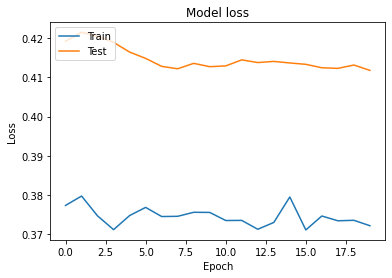

In [87]:
model1.compile(loss = 'binary_crossentropy', optimizer = Adam(1e-5)
              )

epochs = 20
batch_size = 64
history = model1.fit(X_train_, y_train, batch_size = batch_size , epochs = epochs, validation_split=0.2)
plot_learning_curves(history)

## Evaluation du modèle

In [88]:
model2_pred = model1.predict(X_test_)

In [89]:
model2_pred

array([[0.04801334, 0.03472825, 0.02987201, 0.11776194],
       [0.09086487, 0.04503214, 0.14380848, 0.12155046],
       [0.28008106, 0.1837382 , 0.33088937, 0.24612421],
       ...,
       [0.48204252, 0.23344773, 0.63597745, 0.37770203],
       [0.39187977, 0.23397776, 0.80722207, 0.34762815],
       [0.07039604, 0.03950375, 0.04264768, 0.16568749]], dtype=float32)

In [90]:
pred2 = np.zeros((model2_pred.shape[0],4))
for i in range(model2_pred.shape[0]):
  for j in range (4):
    pred2[i,j]=np.round(model2_pred[i,j])   #seuil 0.5


pred2=pd.DataFrame(pred2, columns =["MI","HYP","CD","STTC"])

In [91]:
pred2

,MI,HYP,CD,STTC
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
610,0.0,0.0,0.0,0.0
611,0.0,0.0,0.0,0.0
612,0.0,0.0,1.0,0.0
613,0.0,0.0,1.0,0.0


### MI : Myocardial Infarction

In [92]:
c1 = confusion_matrix(pred2.iloc[:,0],y_test[:,0])
print(c1)
f1 = f1_score(pred2.iloc[:,0],y_test[:,0])
print("Pourcentage d'erreur du dnn pour MI", (1-accuracy_score(pred2.iloc[:,0],y_test[:,0]))*100, " % ")
print("f1-score du dnn pour MI :",f1)

[[477 113]
 [ 10  15]]
Pourcentage d'erreur du dnn pour MI 19.999999999999996  % 
f1-score du dnn pour MI : 0.19607843137254902


### HYP : hypertrophy

In [94]:
c2 = confusion_matrix(pred2.iloc[:,1],y_test[:,1])
print(c2)
f2 = f1_score(pred2.iloc[:,1],y_test[:,1])
print("Pourcentage d'erreur du dnn pour HYP", (1-accuracy_score(pred2.iloc[:,1],y_test[:,1]))*100, " % ")
print("f1-score du dnn pour HYP :",f2)

[[544  71]
 [  0   0]]
Pourcentage d'erreur du dnn pour HYP 11.544715447154474  % 
f1-score du dnn pour HYP : 0.0


### CD : Conduction Disturbance

In [96]:
c3 = confusion_matrix(pred2.iloc[:,2],y_test[:,2])
print(c3)
f3 = f1_score(pred2.iloc[:,2],y_test[:,2])
print("Pourcentage d'erreur du dnn pour CD", (1-accuracy_score(pred2.iloc[:,2],y_test[:,2]))*100, " % ")
print("f1-score du dnn pour CD :",f3)

[[479  65]
 [ 20  51]]
Pourcentage d'erreur du dnn pour CD 13.821138211382111  % 
f1-score du dnn pour CD : 0.5454545454545455


### STTC : ST/T Change

In [97]:
c4 = confusion_matrix(pred2.iloc[:,3],y_test[:,3])
print(c4)
f4 = f1_score(pred2.iloc[:,3],y_test[:,3])
print("Pourcentage d'erreur du dnn pour STTC", (1-accuracy_score(pred2.iloc[:,3],y_test[:,3]))*100, " % ")
print("f1-score du dnn pour STTC :",f4)

[[465 124]
 [ 10  16]]
Pourcentage d'erreur du dnn pour STTC 21.788617886178862  % 
f1-score du dnn pour STTC : 0.19277108433734938
